In [1]:
import os
import subprocess
import sys
import numpy as np
import itertools
from tqdm import tqdm
from IPython.display import display, HTML
top_level_dir = '/'.join( os.getcwd().split( '/' )[ :-2 ] )
if top_level_dir not in sys.path:
    sys.path.append( top_level_dir )

In [8]:
from GenModels.GM.States.GraphicalMessagePassing import DataGraph, \
                                                        GraphHMMFBS
from GenModels.GM.Distributions import Categorical, Dirichlet, TensorTransition, TensorTransitionDirichletPrior

# Expectation Maximization with graphical hidden markov models

The EM algorithm for graph hmms is very similar to the regular baum-welch algorithm, except the transition update involves normalizing over joint parent probabilities:
- E Step:
    - Compute U and V probabilites for each node where
$$
U( n )    = P( \uparrow( n )_y, n_x )
$$
$$
V( n, e ) = P( \downarrow( n, e )_y | n_x )
$$
    - Compute 
    $$ P( x | Y ) $$
    $$ P( x_{p1...pN} | Y ) $$
    $$ P( x_c, x_{p1...pN} | Y ) $$ for each node using the U and V values
    
- M Step:
    - Update 
    $$ P( x_{root} ) = \frac{1}{|roots|}\sum_{r \in roots} P( x_r | Y ) $$
    $$ P( x_c | x_{p1...pN} ) = \frac{ \sum_{ n_c \notin roots }P( x_c, x_{p1...pN} | Y ) }
                                     { \sum_{ n_c \notin roots }P( x_{p1...pN} | Y ) } $$
                                     
    $$ P( y_n | x_n ) = \frac{ \sum_{ n \in nodes }I[ P( x_n | Y ) ]_{ y_n == y^{'} } }
                             { \sum_{ n \in nodes }P( x_n | Y ) } $$

# E Step

In [9]:
def EStep( msg ):
    U, V = msg.filter()
    
    marginal = msg.marginalProb( U, V )
    
    # Compute log P( x | Y ), log P( x_p1..pN | Y ) and log P( x_c, x_p1..pN | Y )
    node_smoothed = msg.nodeSmoothed( U, V, msg.nodes )
    parents_smoothed = msg.parentsSmoothed( U, V, msg.nodes )
    node_parents_smoothed = msg.parentChildSmoothed( U, V, msg.nodes )
    
    # The probabilities are normalized, so don't need them in log space anymore
    node_smoothed = [ ( n, np.exp( val ) ) for n, val in node_smoothed ]
    parents_smoothed = [ ( n, np.exp( val ) ) for n, val in parents_smoothed ]
    node_parents_smoothed = [ ( n, np.exp( val ) ) for n, val in node_parents_smoothed ]
    
    return dict( node_smoothed ), dict( parents_smoothed ), dict( node_parents_smoothed ), marginal

# M Step

In [10]:
def logWithZero( val ):
    # Helper function to avoid numpy divide by 0 warning in np.log
    ans = np.empty_like( val )
    ans[ val != 0.0 ] = np.log( val[ val != 0.0 ] )
    ans[ val == 0.0 ] = np.NINF
    return ans

def MStep( msg, node_smoothed, parents_smoothed, node_parents_smoothed ):
    
    # Initialize the root distritubion, transition distribution and emission distribution
    initial_dist = np.zeros_like( msg.pi0 )
    
    trans_dist_numerator = {}
    trans_dist_denominator = {}
    for n_parents_1, val in msg.pis.items():
        trans_dist_numerator[ n_parents_1 ] = np.zeros_like( val )
        trans_dist_denominator[ n_parents_1 - 1 ] = np.zeros( val.shape[ :-1 ] )
            
    emission_dist_numerator = np.zeros_like( msg.emission_dist )
    emission_dist_denominator = np.zeros_like( msg.pi0 )
    
    # Update the root distribution
    for root in msg.roots:
        initial_dist += node_smoothed[ root ]
    initial_dist /= msg.roots.size
        
    # Update the transition distributions
    for node in msg.nodes:
        n_parents = msg.nParents( node )
        if( n_parents == 0 ):
            continue
        
        trans_dist_numerator[ n_parents + 1 ] += node_parents_smoothed[ node ]     
        trans_dist_denominator[ n_parents ] += parents_smoothed[ node ]
        
    # Update the emission distribution
    for node, ys in zip( msg.nodes, msg.ys ):
        measurements = ys.shape[ 0 ]
        
        for y in ys:
            emission_dist_numerator[ :, y ] += node_smoothed[ node ]
        emission_dist_denominator += node_smoothed[ node ] * measurements

    assert np.allclose( initial_dist.sum( axis=-1 ), 1.0 )
    for n_parents, parent_dist in trans_dist_denominator.items():
        assert np.allclose( ( trans_dist_numerator[ n_parents + 1 ] / parent_dist[ ..., None ] ).sum( axis=-1 ), 1.0 )
    assert np.allclose( ( emission_dist_numerator / emission_dist_denominator[ :, None ] ).sum( axis=-1 ), 1.0 )
        
    # Update msg's parameters
    msg.pi0 = logWithZero( initial_dist )
    
    for n_parents, parent_dist in trans_dist_denominator.items():
        msg.pis[ n_parents + 1 ] = logWithZero( trans_dist_numerator[ n_parents + 1 ] / parent_dist[ ..., None ] )
        
    msg.emission_dist = logWithZero( emission_dist_numerator / emission_dist_denominator[ :, None ] )
    
    return msg

# Initialize graph

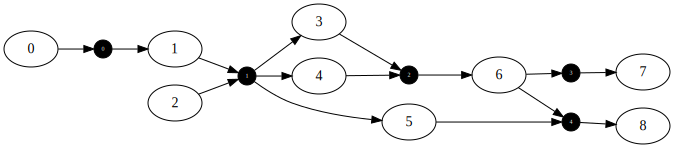

In [11]:
# Latent state size of 3 so that we can use rgb values to interpret them
d_latent     = 3
d_obs        = 2

# This is the number of times we measure an emission from the same 
# latent state for a node
measurements = 3

graph = DataGraph()
graph.addEdge( parents=[ 0 ], children=[ 1 ] )
graph.addEdge( parents=[ 1, 2 ], children=[ 3, 4, 5 ] )
graph.addEdge( parents=[ 3, 4 ], children=[ 6 ] )
graph.addEdge( parents=[ 6 ], children=[ 7 ] )
graph.addEdge( parents=[ 5, 6 ], children=[ 8 ] )

# Add random data that is either 0 or 1
for node in graph.nodes:
    data = Categorical.generate( D=d_obs, size=measurements )
    graph.setNodeData( node, data )

feedback_set = np.array( [ 3, 5 ] )
graph.draw( horizontal=True )

# Initialize model

In [12]:
# Initial dist
initial_dist = Categorical( hypers=dict( alpha=np.ones( d_latent ) ) )
initial_sample = initial_dist.pi

# Check how many transition distributions we need
all_transition_counts = set()
for parents in graph.edge_parents:
    ndim = len( parents ) + 1
    all_transition_counts.add( ndim )

# Create the transition distribution
transition_dists = {}
transition_samples = []
for ndim in all_transition_counts:
    dist = TensorTransition( hypers=dict( alpha=np.ones( [ d_latent for _ in range( ndim ) ] ) ) )
    transition_dists[ ndim ] = dist
    transition_samples.append( dist.pi )

# Emission dist
emission_dist = TensorTransition( hypers=dict( alpha=np.ones( ( d_latent, d_obs ) ) ) )
emission_sample = emission_dist.pi

# Create the message passer and initialize
msg = GraphHMMFBS()
msg.updateParams( initial_sample, transition_samples, emission_sample, data_graphs=[ ( graph, feedback_set ) ] )

# Interpret probabilities as rgb values

In [13]:
import matplotlib

# Path to tmp folder where the intermediate images will be rendered
tmp_folder = top_level_dir + '/GenModels/tmp'

def genStyle( probs ):
    color = matplotlib.colors.to_hex( probs )
    return dict( fontcolor='black', style='filled', color=color )

# Run the EM algorithm and draw the graph's latent states at each iteration

In [14]:
iters = 500
tit = tqdm( range( iters ) )
last_marginal = 9999
for i in tit:
    node_smoothed, parents_smoothed, node_parents_smoothed, marginal = EStep( msg )
    msg = MStep( msg, node_smoothed, parents_smoothed, node_parents_smoothed )

    styles = dict( [ ( node, genStyle( probs ) ) for node, probs in node_smoothed.items() ] )
    node_to_style_key = dict( [ ( node, node ) for node in msg.nodes ] )

    output_name = 'graph_%d'%( i )

    # Draw the graph
    msg.toGraph().draw( styles=styles, 
                        horizontal=True, 
                        node_to_style_key=node_to_style_key, 
                        output_folder=tmp_folder, 
                        output_name=output_name )

    tit.set_description( '%5.3f'%( marginal ) )
    if( np.isclose( marginal, last_marginal ) ):
        break
    last_marginal = marginal

-18.375:   6%|▌         | 29/500 [00:07<02:01,  3.89it/s]

# There are different colors even though the data was uniformly random because the size of the dataset was small and EM tends to overfit

In [15]:
# Convert the images to a gif using ImageMagick
image_paths = [ tmp_folder + '/graph_%d.png'%( j ) for j in range( i + 1 ) ]
commands = [ 'convert', '-loop', '0', '-delay', '20' ] + image_paths + [ 'hmm_em.gif' ]
subprocess.call( commands )

# Delete the contents of tmp
subprocess.call( [ 'rm' ] + image_paths )

# Display the gif
HTML( '<img src="./%s">'%( 'hmm_em.gif' ) )